In [1]:
import pandas as pd
import re
import numpy as np
import glob
import os
from collections import defaultdict
import networkx
from networkx.algorithms.components.connected import connected_components
from packages import npomix
import time
from datetime import datetime
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

In [2]:
start = time.time()

In [3]:
edges_path = "./inputs/gnps_function/96d708b13d1e401fbb2fb58ccbcbc78c..selfloop"
nodes_path = "./inputs/gnps_function/c2a89b977ead4342b42900d7023ec110.clustersummary"

In [4]:
nodes_df = pd.read_csv(nodes_path,sep='\t')

nodes_df[:5]

,AllGroups,DefaultGroups,EvenOdd,G1,G2,G3,G4,G5,G6,GNPSLinkout_Cluster,...,SpectrumID,UniqueFileSources,UniqueFileSourcesCount,cluster index,componentindex,number of spectra,parent mass,precursor charge,precursor mass,sum(precursor intensity)
0,,G1,1,8,0,0,0,0,0,https://gnps.ucsd.edu//ProteoSAFe/result.jsp?t...,...,NaN,Blongum44Bv1.3.mzXML|Bact_sp_9_1_42FAA_V2.3.mz...,7,2,-1,8,84.043,0,84.043,12004.0
1,,G1,1,14,0,0,0,0,0,https://gnps.ucsd.edu//ProteoSAFe/result.jsp?t...,...,NaN,SspCM6v1.2.mzXML|Bact_cacc_CL03T12C61_V1.3.mzX...,12,3,-1,14,84.043,0,84.043,23389.0
2,,G1,1,4,0,0,0,0,0,https://gnps.ucsd.edu//ProteoSAFe/result.jsp?t...,...,NaN,Acti_vis_C505_V3.3.mzXML|Bact_sp_1_1_6_V2.3.mz...,4,5,-1,4,84.043,0,84.043,8576.0
3,,G1,1,21,0,0,0,0,0,https://gnps.ucsd.edu//ProteoSAFe/result.jsp?t...,...,NaN,SspCM7v1.2.mzXML|SspCM6v1.2.mzXML|Bact_cacc_CL...,12,6,1488,21,84.044,0,84.044,48410.0
4,,G1,1,15,0,0,0,0,0,https://gnps.ucsd.edu//ProteoSAFe/result.jsp?t...,...,NaN,Bact_cacc_CL03T12C61_V1.3.mzXML|Bact_sp_9_1_42...,12,11,1488,15,84.043,0,84.043,35506.0


In [5]:
clusterindex_list = []

for i,r in nodes_df.iterrows():
    if type(r['LibraryID']) != float:
        clusterindex_list.append(r['cluster index'])
        
clusterindex_list

[5668,
 7209,
 10731,
 10732,
 10763,
 11459,
 11636,
 11637,
 11963,
 12071,
 12082,
 12132,
 12163,
 12578,
 12823,
 12830,
 13100,
 13395,
 13499,
 13518,
 13708,
 15307,
 16294,
 16716,
 16853,
 16854,
 17578,
 18379,
 18470,
 20508,
 20714,
 22725,
 24958,
 25004,
 25026,
 25059,
 25150,
 25291,
 25633,
 25634,
 25639,
 25649,
 26097,
 26110,
 26114,
 27121,
 27357,
 27522,
 27631,
 27632,
 27634,
 27921,
 28039,
 28267,
 28506,
 28530,
 28531,
 28558,
 28600,
 28634,
 28672,
 28675,
 28799,
 28834,
 28882,
 28897,
 29029,
 29788,
 29793,
 29856,
 29968,
 30020,
 30034,
 30056,
 30080,
 30107,
 30112,
 30157,
 30260,
 30285,
 30317,
 31054,
 31526,
 31656,
 31714,
 32103,
 32153,
 32155,
 32160,
 32163,
 32178,
 32181,
 33168,
 33195,
 33254,
 33284,
 33332,
 33717,
 34458,
 35036,
 35127,
 35235,
 35239,
 35244,
 35252,
 35343,
 35434,
 35447,
 35614,
 35710,
 35848,
 36035,
 36109,
 36117,
 36211,
 36534,
 36689,
 36806,
 36962,
 37367,
 40007,
 40378,
 40526,
 40732,
 40763,
 4

In [6]:
edges_df = pd.read_csv(edges_path,sep='\t')

def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary,column1,column2,column3):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['MF%s'%count].append(fam_member)
    return dictionary

def main_get_families(gnps_df):
    targets_list = np.unique([gnps_df.CLUSTERID1,gnps_df.CLUSTERID2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,gnps_df,'CLUSTERID1','CLUSTERID2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    mf_dict = defaultdict(list)
    mf_dict = get_family_dict(C,gnps_df,mf_dict,'CLUSTERID1','CLUSTERID2','Cosine')
    return mf_dict

mf_dict = main_get_families(edges_df)

mf_dict

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


defaultdict(list,
            {'MF1': [2],
             'MF2': [3],
             'MF3': [5],
             'MF4': [5604,
              15876,
              6,
              3784,
              177928,
              11,
              12204,
              15884,
              64785,
              3987,
              5589,
              6421,
              87671,
              2128764,
              64829,
              3806],
             'MF5': [18],
             'MF6': [36],
             'MF7': [47],
             'MF8': [63],
             'MF9': [384],
             'MF10': [473],
             'MF11': [731],
             'MF12': [732],
             'MF13': [733],
             'MF14': [734],
             'MF15': [741],
             'MF16': [742],
             'MF17': [743],
             'MF18': [745, 5075, 3357, 3783],
             'MF19': [753],
             'MF20': [1153],
             'MF21': [1354],
             'MF22': [1416],
             'MF23': [13128, 3316, 174591],
             

In [7]:
for ion in clusterindex_list:
    print(ion)

5668
7209
10731
10732
10763
11459
11636
11637
11963
12071
12082
12132
12163
12578
12823
12830
13100
13395
13499
13518
13708
15307
16294
16716
16853
16854
17578
18379
18470
20508
20714
22725
24958
25004
25026
25059
25150
25291
25633
25634
25639
25649
26097
26110
26114
27121
27357
27522
27631
27632
27634
27921
28039
28267
28506
28530
28531
28558
28600
28634
28672
28675
28799
28834
28882
28897
29029
29788
29793
29856
29968
30020
30034
30056
30080
30107
30112
30157
30260
30285
30317
31054
31526
31656
31714
32103
32153
32155
32160
32163
32178
32181
33168
33195
33254
33284
33332
33717
34458
35036
35127
35235
35239
35244
35252
35343
35434
35447
35614
35710
35848
36035
36109
36117
36211
36534
36689
36806
36962
37367
40007
40378
40526
40732
40763
40764
40767
40866
41055
41335
41339
42484
42520
42528
42573
42701
42704
42706
42725
42965
43185
43464
43663
44263
44901
47763
47765
47774
47775
47833
47845
49057
49365
49408
49656
49714
49715
49960
50705
50855
51164
51398
51400
51406
51577
54479
54517


628627
628659
628727
628763
628819
628840
628880
628881
628903
628935
629057
629070
629077
629214
629229
629317
629440
629643
629688
629816
629989
630022
630101
630104
630461
630695
630970
630983
631014
631233
631287
631317
631384
631389
631405
631418
631422
631423
631427
631450
631477
631500
631501
631539
631587
631718
631749
632046
632082
632430
632436
632437
632441
632445
632454
632476
632483
632484
632493
632498
632499
632512
632519
632572
632588
632623
632669
632703
632727
632729
632830
632874
632900
632946
632952
632969
632981
632998
633000
633100
633110
633143
633147
633181
633188
633284
633482
633486
633520
633521
633531
635656
635845
635847
635849
635852
635855
635859
635862
635870
635875
635882
635885
635886
635890
635901
635902
635911
635927
635931
635939
635940
635949
635955
635960
635962
635968
635970
635980
636002
636003
636006
636007
636019
636020
636024
636044
636045
636067
636085
636106
636115
636124
636145
636181
636183
636185
636190
636195
636197
636209
636216
636220

971722
971732
971782
971800
971825
971841
971867
971878
972052
972093
972099
972132
972242
972277
972303
972462
972529
972673
972719
972738
972772
972777
972783
972786
972832
972930
972945
972967
972976
973116
973117
973142
973309
973386
973405
973754
973785
973891
974030
974036
974127
974180
974182
974425
974433
974528
974574
974588
974777
975242
975646
976343
976734
976797
977045
977449
980333
980336
980549
980581
980952
980955
980964
981060
981089
981531
981713
981751
981771
981875
981921
982386
982390
982391
982402
982639
982710
982719
982930
983000
983352
984843
984993
985084
985146
985148
985149
985155
985173
985174
985185
985368
985371
985501
985595
987214
987216
987221
987223
987228
987229
987238
987239
987258
987259
987264
987270
987271
987286
987308
987960
989165
989171
989306
989377
989378
989379
989383
989385
989386
989396
989564
989592
989683
989703
989840
989872
989905
989913
989922
990032
990096
990146
990337
991242
991243
991897
992338
993722
993774
993802
994339
994404

1327151
1327177
1327179
1327202
1327207
1327211
1327234
1327248
1327265
1327270
1327304
1327320
1327377
1327485
1327545
1327548
1327618
1327682
1327718
1327812
1327829
1328030
1328040
1328047
1328098
1328117
1328240
1328365
1328430
1328484
1328653
1328660
1328664
1328667
1328684
1328687
1330757
1331972
1332629
1332678
1332682
1332749
1332831
1332852
1332854
1332873
1332886
1332887
1332889
1332925
1339079
1339688
1353152
1353228
1353338
1354087
1355342
1355454
1355521
1355539
1355586
1355625
1355672
1355673
1355684
1355720
1356048
1356050
1356067
1356482
1357772
1358172
1358243
1358246
1358252
1358311
1358314
1358317
1358332
1358333
1358338
1358339
1358340
1358382
1358392
1358398
1358419
1358448
1358468
1358490
1358524
1358539
1359073
1359152
1359175
1359227
1359356
1359454
1359712
1359748
1359753
1361374
1361573
1361583
1363199
1363283
1363367
1364278
1364476
1364495
1364499
1365196
1365356
1367586
1367663
1367716
1367737
1369752
1369824
1369853
1369858
1369886
1369922
1369931
1369954


2118126
2118191
2118716
2118735
2119124
2119149
2119840
2119851
2119990
2120674
2121332
2121535
2121543
2121651
2121716
2121780
2122388
2123298
2123322
2123775
2123787
2124258
2124459
2124797
2124989
2125030
2125597
2126198
2126256
2126821
2127363
2127453
2127479
2127480
2127511
2129734
2133133
2133159
2134061
2134065
2134112
2134332
2134335
2134336
2134343
2134344
2134347
2134359
2134362
2134367
2134375
2135502
2135627
2136193
2137179
2138279
2138314
2138315
2138316
2138321
2138322
2138323
2138324
2138325
2138336
2138427
2138428
2138429
2138431
2138432
2138433
2138434
2138436
2138437
2138438
2138440
2138441
2138442
2138443
2138445
2138449
2138450
2138452
2138453
2138454
2138461
2138471
2138472
2138474
2138475
2138476
2138477
2138478
2138479
2138485
2138486
2138496
2138497
2138498
2138499
2138501
2138502
2138503
2138504
2138505
2138698
2138978
2138988
2138993
2139105
2139229
2139439
2139479
2139607
2140238
2140246
2140250
2140254
2140255
2140259
2140273
2140305
2140317
2140361
2140381


In [8]:
lcms_file_list = []

for item in nodes_df['UniqueFileSources']:
    for lcms_file in item.split('|'):
        if lcms_file not in lcms_file_list:
            print(lcms_file)
            lcms_file_list.append(lcms_file)

Blongum44Bv1.3.mzXML
Bact_sp_9_1_42FAA_V2.3.mzXML
SspSR1v1.2.mzXML
Clos_orbi_1_3_50AFAA_V1.3.mzXML
Clos_clos_2_1_49FAA_V1.3.mzXML
SspCM7v1.2.mzXML
Bact_vulg_CL09T03C04_V1.3.mzXML
SspCM6v1.2.mzXML
Bact_cacc_CL03T12C61_V1.3.mzXML
SspOBRC6v1.2.mzXML
Bact_frag_CL07T12C05_V1.3.mzXML
Para_merd_CL03T12C32_V1.3.mzXML
Bact_dore_CL02T00C15_V1.3.mzXML
Clos_bact_OBRC5-5_V1.2.mzXML
Bacteroides_sp_1_1_30_V1.3.mzXML
Acti_vis_C505_V3.3.mzXML
Bact_sp_1_1_6_V2.3.mzXML
Bact_cell_CL02T12C19_V1.3.mzXML
Bact_frag_CL07T00C01_V1.3.mzXML
Bact_ster_CC31F_V1.3.mzXML
Bact_thet_CL09T03C10_V1.3.mzXML
GCA_001625105.1.mzXML
GCA_000012265.1.mzXML
BspMSTE12v1.3.mzXML
Bact_dore_CL02T12C06_V1.3.mzXML
Bifi_brev_HPH0326_V1.3.mzXML
Para_merd_CL09T00C40_V1.3.mzXML
GCA_001562525.1.mzXML
GCA_000506385.2.mzXML
GCA_003324555.1.mzXML
Blongum35Bv1.3.mzXML
SspBS29av1.2.mzXML
Bact_frag_CL03T12C07_V1.3.mzXML
ERX2291258.1.mzXML
ERX2291789.1.mzXML
ERX2291921.1.mzXML
ERX2291699.1.mzXML
Kleb_pneu_WGLW2_V1.1.mzXML
GCA_012367695.5.mzXML
GC

ERX2291652.1.mzXML
ERX2291397.1.mzXML
ERX2291406.1.mzXML
Clos_clos_2_1_49FAA_V1.2.mzXML
ERX2291807.1.mzXML
ERX2291731.1.mzXML
ERX2291411.1.mzXML
ERX2291915.1.mzXML
ERX2291645.1.mzXML
ERX2291395.1.mzXML
ERX2291709.1.mzXML
ERX2291800.1.mzXML
ERX2291376.1.mzXML
ERX2291737.1.mzXML
ERX2291788.1.mzXML
ERX2291713.1.mzXML
ERX2291589.1.mzXML
ERX2291855.1.mzXML
ERX2291363.1.mzXML
ERX2291660.1.mzXML
ERX2291620.1.mzXML
ERX2291402.1.mzXML
ERX2291650.1.mzXML
ERX2291349.1.mzXML
ERX2291890.1.mzXML
ERX2291431.1.mzXML
CspBV3C26v1.1.mzXML
ERX2291641.1.mzXML
ERX2291799.1.mzXML
2747842505.1.mzXML
2791354866.1.mzXML
2528311045.1.mzXML
GCA_010672305.7.mzXML
GCA_010672505.5.mzXML
GCA_010672365.8.mzXML
GCA_010672695.3.mzXML
GCA_010692425.10.mzXML
GCA_010692685.5.mzXML
GCA_010692555.1.mzXML
GCA_010672695.10.mzXML
GCA_010692425.3.mzXML
GCA_010672305.5.mzXML
GCA_010672205.1.mzXML
GCA_010672505.8.mzXML
GCA_010672695.1.mzXML
GCA_010672695.5.mzXML
GCA_010672505.7.mzXML
GCA_010672205.6.mzXML
GCA_010672305.1.mzXML
GCA

ERS4341472.1.mzXML
ERS4356285.1.mzXML
ERX2291663.1.mzXML
ERS4341633.1.mzXML
ERS4341702.1.mzXML
ERS4341514.1.mzXML
ERS4346486.1.mzXML
ERX2291698.1.mzXML
ERS4341485.1.mzXML
ERS4346434.1.mzXML
ERS4341515.1.mzXML
ERS4346418.1.mzXML
ERS4346572.1.mzXML
ERS4341606.1.mzXML
ERS4341538.1.mzXML
ERS4346501.1.mzXML
ERS4341476.1.mzXML
ERS4341642.1.mzXML
ERS4341693.1.mzXML
ERS4341670.1.mzXML
ERS4341636.1.mzXML
ERS4341375.1.mzXML
ERS4346406.1.mzXML
ERS4356322.1.mzXML
ERS4356211.1.mzXML
ERS4341509.1.mzXML
ERS4356250.1.mzXML
ERS4356247.1.mzXML
ERS4346505.1.mzXML
ERS4341690.1.mzXML
ERS4346582.1.mzXML
ERS4341482.1.mzXML
ERS4341576.1.mzXML
ERX2291784.1.mzXML
ERX2291278.1.mzXML
ERS4356177.1.mzXML
ERS4356314.1.mzXML
DS570624.19.mzML
ERS4356252.1.mzXML
ERS4356315.1.mzXML
ERS4356313.1.mzXML
ERS4356254.1.mzXML
2515154177.12.mzXML
2515154177.10.mzXML
2524614807.14.mzXML
2515154177.6.mzXML
2518285562.11.mzXML
2524614807.13.mzXML
2518285561.5.mzXML
2515154177.11.mzXML
2517572145.11.mzXML
2517572145.3.mzXML
2528311

GCA_000009485.31.mzML
GCA_000018505.6.mzML
GCA_000959525.6.mzML
GCA_000981305.18.mzXML
GCA_003568605.2.mzML
GCA_000018505.23.mzML
GCA_003568605.5.mzML
GCA_000981305.18.mzML
GCA_000009485.25.mzML
GCA_000981305.13.mzML
GCA_000959505.19.mzML
GCA_000959525.16.mzML
GCA_000981305.20.mzXML
GCA_000286575.24.mzML
GCA_000009485.12.mzML
GCA_000018505.19.mzML
GCA_000009485.8.mzML
GCA_000959525.8.mzML
GCA_000981305.8.mzML
GCA_000981305.20.mzML
GCA_000959525.4.mzML
GCA_000959505.8.mzML
ERS4341570.1.mzXML
GCA_000018505.16.mzML
GCA_000286575.7.mzML
GCA_003568605.17.mzML
GCA_003568605.21.mzML
GCA_000009485.34.mzML
GCA_000009485.14.mzML
GCA_000981305.1.mzML
GCA_000009485.19.mzML
GCA_000286575.3.mzML
ERS4346496.1.mzXML
ERS4341519.1.mzXML
ERS4341583.1.mzXML
GCA_002941025.1.mzML
GCA_000018505.3.mzML
GCA_000981305.17.mzXML
GCA_000981305.19.mzXML
GCA_000981305.19.mzML
GCA_000981305.17.mzML
GCA_000959505.3.mzML
GCA_000981305.21.mzXML
GCA_000286575.8.mzML
GCA_000959525.13.mzML
GCA_000959525.3.mzML
GCA_00001850

GCA_000377125.16.mzXML
GCA_000702365.8.mzXML
GCA_000377165.8.mzXML
GCA_000377165.7.mzXML
2517572165.7.mzXML
GCA_000424965.8.mzXML
GCA_000482585.4.mzXML
GCA_000377545.1.mzXML
2561511112.6.mzXML
GCA_000156695.4.mzXML
GCA_000213055.3.mzXML
GCA_000514715.8.mzXML
GCA_000424965.3.mzXML
GCA_000240165.22.mzXML
GCA_000424825.6.mzXML
GCA_003610995.1.mzXML
GCA_000415505.4.mzXML
GCA_000514995.7.mzXML
GCA_003610995.6.mzXML
GCA_000156695.6.mzXML
GCA_000424825.9.mzXML
GCA_000377125.14.mzXML
GCA_000424765.8.mzXML
GCA_000158975.3.mzXML
GCA_000377125.15.mzXML
GCA_000424825.4.mzXML
2561511112.3.mzXML
GCA_000424785.9.mzXML
GCA_000426165.8.mzXML
GCA_000377165.1.mzXML
GCA_000424965.2.mzXML
GCA_000515055.1.mzXML
GCA_000377165.2.mzXML
2517572165.9.mzXML
GCA_000424845.8.mzXML
GCA_000739105.1.mzXML
GCA_000702365.5.mzXML
GCA_000424965.9.mzXML
GCA_000158915.3.mzXML
GCA_000424785.7.mzXML
GCA_000702365.6.mzXML
GCA_000426325.9.mzXML
GCA_000415505.6.mzXML
GCA_000514715.7.mzXML
GCA_000377125.10.mzXML
GCA_000515055.8.m

In [9]:
len(lcms_file_list)

2982

In [10]:
def get_presence_files(nodes_df):
    for unique_list in list(nodes_df[nodes_df['cluster index'] == ion]['UniqueFileSources']):
        return list(unique_list.split('|'))

all_rows_list,testing_indexes_list = [],[]
for ion in clusterindex_list:
    subset_edges = edges_df[(edges_df.CLUSTERID1 == ion) | (edges_df.CLUSTERID2 == ion)]
    cosine = round(max(subset_edges['Cosine']),2)
    presence_list = get_presence_files(nodes_df)
    single_row_list = []
    for lcms_file in lcms_file_list:
        if lcms_file in presence_list:
            single_row_list.append(cosine)
        else:
            single_row_list.append(0)
    all_rows_list.append(single_row_list)
    testing_indexes_list.append(ion)
    
all_rows_list

pre_testing_df = pd.DataFrame(all_rows_list,index=testing_indexes_list,columns=lcms_file_list)

pre_testing_df

,Blongum44Bv1.3.mzXML,Bact_sp_9_1_42FAA_V2.3.mzXML,SspSR1v1.2.mzXML,Clos_orbi_1_3_50AFAA_V1.3.mzXML,Clos_clos_2_1_49FAA_V1.3.mzXML,SspCM7v1.2.mzXML,Bact_vulg_CL09T03C04_V1.3.mzXML,SspCM6v1.2.mzXML,Bact_cacc_CL03T12C61_V1.3.mzXML,SspOBRC6v1.2.mzXML,...,GCA_012367695.4.mzXML,GCA_000377145.7.mzXML,2517434008.3.mzXML,GCA_000020025.18.mzXML,GCA_000020025.16.mzXML,GCA_000020025.14.mzXML,GCA_000020025.10.mzXML,GCA_000020025.5.mzXML,GCA_000020025.8.mzXML,GCA_000020025.12.mzXML
5668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2710780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2710856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2710871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
def get_final_df(training_df,testing_df,neighbors_array,results_folder):
    final_df = pd.DataFrame(columns=('metabolite_ID','predicted_GCFs','max_jaccard','parent_mass','sum_intensity','GNPS_lib_hit'))
    for i,ccms_id in enumerate(testing_df.index):
        jaccard_scores = []
        for j in range(0,len(neighbors_array[i])):
            query_bgc = neighbors_array[i][j]
            bgc_fp = training_df[training_df['label'] == query_bgc].iloc[0]
            bgc_fp = bgc_fp.drop("label")
            ms_fp = testing_df.loc[ccms_id]
            bgc_binary = npomix.get_binary(bgc_fp)
            ms_binary = npomix.get_binary(ms_fp)
            jaccard_scores.append(jaccard_score(bgc_binary,ms_binary))
        max_jaccard = round(max(jaccard_scores),2)
        parentmass = nodes_df[nodes_df['cluster index'] == ccms_id]['precursor mass'].item()
        intensity = nodes_df[nodes_df['cluster index'] == ccms_id]['sum(precursor intensity)'].item()
        libhit = nodes_df[nodes_df['cluster index'] == ccms_id]['LibraryID'].item()
        final_df.loc[i] = ccms_id,neighbors_array[i],max_jaccard,parentmass,intensity,libhit
    final_df.to_csv("%sfinal_df-derep-NPOmix1.0-%s.txt"%(results_folder,current_date),sep="\t",index_label=False)
    return final_df

In [12]:
ena_df_file = "./ena_dict-210315.csv"
input_bigscape_net = "./bigscape_all_c030.txt"
antismash_folder = "./test/antismash_only_gbk/"
results_folder = "./latest_results/test_validation_derep-230324/"

current_date = datetime.today().strftime('%Y%m%d')

if not os.path.isdir(results_folder):
    os.mkdir(results_folder)

k_value = 3

merged_ispec_mat = npomix.get_merged_ispec_mat(pre_testing_df)
merged_ispec_mat = npomix.renaming_merged_ispec_mat(ena_df_file,merged_ispec_mat)
print('Obtaining BiG-SCAPE dataframe and BiG-SCAPE dictionary')
bigscape_df,bigscape_dict = npomix.get_bigscape_df(ena_df_file,input_bigscape_net)
bigscape_df,bigscape_dict2 = npomix.rename_bigscape_df(antismash_folder,bigscape_df,bigscape_dict)
print('BiG-SCAPE create with %s GCFs'%len(bigscape_dict))
strain_list,bgcs_list = npomix.get_strain_list(bigscape_df)
print('Creating training dataframe')
affinity_df,affinity_bgcs = npomix.get_pre_training_df(bigscape_df,bigscape_dict2,strain_list,bgcs_list)
affinity_df = npomix.renaming_affinity_df(affinity_df)
networked_cols = npomix.get_networked_cols(merged_ispec_mat,affinity_df)
training_df,training_bgcs = npomix.get_training_df(affinity_df,networked_cols,results_folder,affinity_bgcs)
bgcs_df = pd.DataFrame(training_bgcs, columns=['bgcs'])
testing_df = npomix.get_testing_df(merged_ispec_mat,networked_cols,results_folder)
print('Running KNN using k equals to %s'%k_value)
neighbors_array = npomix.running_knn(training_df,testing_df,k_value)
print('Creating final dataframe')
final_df = get_final_df(training_df,testing_df,neighbors_array,results_folder)

Obtaining BiG-SCAPE dataframe and BiG-SCAPE dictionary
BiG-SCAPE create with 997 GCFs
Creating training dataframe
Running KNN using k equals to 3
Creating final dataframe


In [14]:
testing_df.shape,training_df.shape

((10873, 942), (3487, 943))

In [13]:
final_df = final_df[final_df['max_jaccard'] > 0]
final_df = final_df.sort_values(by='max_jaccard',ascending=False)
final_df = final_df.reset_index(drop=True)

final_df

,metabolite_ID,predicted_GCFs,max_jaccard,parent_mass,sum_intensity,GNPS_lib_hit
0,5668,"[GCF460, GCF473, GCF72]",1.00,116.426,3114140.0,Levulinic acid - 40.0 eV
1,985368,"[GCF473, GCF460, GCF72]",1.00,339.325,4523890.0,"Spectral Match to 13-Docosenamide, (Z)- from N..."
2,981875,"[GCF5, GCF3, GCF2]",1.00,339.207,2109870.0,"(8,8-dimethyl-2,10-dioxo-9H-pyrano[2,3-f]chrom..."
3,981921,"[GCF5, GCF3, GCF2]",1.00,339.200,5064400.0,"(8,8-dimethyl-2,10-dioxo-9H-pyrano[2,3-f]chrom..."
4,985084,"[GCF446, GCF446, GCF446]",1.00,339.287,0.0,Spectral Match to Monoelaidin from NIST14
...,...,...,...,...,...,...
5370,1934883,"[GCF110, GCF59, GCF59]",0.01,514.284,11260400.0,"2-((4R)-4-((5R,7R,8R,9S,10S,12S,13R,17R)-7,12-..."
5371,965605,"[GCF493, GCF101, GCF493]",0.01,338.342,112287000.0,"Spectral Match to 13-Docosenamide, (Z)- from N..."
5372,1908734,"[GCF192, GCF191, GCF191]",0.01,506.384,2200070.0,Ile/Leu-DCA
5373,1906838,"[GCF191, GCF191, GCF181]",0.01,506.350,682080.0,Ile/Leu-DCA


In [36]:
final_df[final_df['GNPS_lib_hit'].str.contains('Rosamicin')]

,metabolite_ID,predicted_GCFs,max_jaccard,parent_mass,sum_intensity,GNPS_lib_hit
1158,2118735,"[GCF347, GCF347, GCF346]",1.0,582.364,633747.0,Rosamicin
2411,2118716,"[GCF347, GCF347, GCF352]",0.5,583.416,8212370.0,Rosamicin


In [37]:
bigscape_dict['GCF347']

['BGC0000018.1',
 'AUGH01000019.1.region001',
 'BGC0000166.1',
 'BGC0001812.1',
 'BGC0001830.1']

In [15]:
mibig_df = pd.read_csv("./matched_mibig_gnps_update.tsv",sep='\t')

mibig_name_dict = dict(zip(mibig_df['mibig_id'],mibig_df['mibig_name']))

ccmsid_mibig_dict = dict(zip(mibig_df['# mgf_spectrum_id'],mibig_df['mibig_id']))

ccmsid_mibig_dict

{'CCMSLIB00000001552': 'BGC0001000',
 'CCMSLIB00000006865': 'BGC0000001',
 'CCMSLIB00000075009': 'BGC0000950',
 'CCMSLIB00000075016': 'BGC0000950',
 'CCMSLIB00000075305': 'BGC0000055',
 'CCMSLIB00000075306': 'BGC0000055',
 'CCMSLIB00000075307': 'BGC0000706',
 'CCMSLIB00000075308': 'BGC0000706',
 'CCMSLIB00000075309': 'BGC0000724',
 'CCMSLIB00000075310': 'BGC0000724',
 'CCMSLIB00000075311': 'BGC0000455',
 'CCMSLIB00000075312': 'BGC0000455',
 'CCMSLIB00000075313': 'BGC0001453',
 'CCMSLIB00000075320': 'BGC0000985',
 'CCMSLIB00000075321': 'BGC0000985',
 'CCMSLIB00000075322': 'BGC0000985',
 'CCMSLIB00000075323': 'BGC0000985',
 'CCMSLIB00000075324': 'BGC0000985',
 'CCMSLIB00000075325': 'BGC0000985',
 'CCMSLIB00000075331': 'BGC0000016',
 'CCMSLIB00000075332': 'BGC0000016',
 'CCMSLIB00000077217': 'BGC0001310',
 'CCMSLIB00000077218': 'BGC0001310',
 'CCMSLIB00000078898': 'BGC0000901',
 'CCMSLIB00000081213': 'BGC0000389',
 'CCMSLIB00000081265': 'BGC0000820',
 'CCMSLIB00000081266': 'BGC0000820',
 

In [16]:
true_count = 0
total_count = 0

for i,r in final_df[final_df['max_jaccard'] >= 0].iterrows():
    libhit = str(nodes_df[nodes_df['cluster index'] == r['metabolite_ID']]['LibraryID'].item())
    specID = str(nodes_df[nodes_df['cluster index'] == r['metabolite_ID']]['SpectrumID'].item())
    bgchits_list = []
    match = False
    true_false_list = []
    for gcf in r['predicted_GCFs']:
        for bgc in bigscape_dict2[gcf]:
            bgc = bgc.split('.')[0]
            if 'BGC' in bgc:
                if bgc in mibig_name_dict:
                    bgchits_list.append(mibig_name_dict[bgc])
                    if specID in ccmsid_mibig_dict:
                        match = True
                        if ccmsid_mibig_dict[specID] == bgc:
                            print(r['metabolite_ID'],'true',gcf,specID,ccmsid_mibig_dict[specID],bgc,libhit)
                            true_false_list.append('true')
                        else:
                            print(r['metabolite_ID'],'false',gcf,specID,ccmsid_mibig_dict[specID],bgc,'mibig=%s'%mibig_name_dict[bgc],'gnps=%s'%libhit)
                            true_false_list.append('false')
#                     else:
#                         print('missing %s'%specID)
#                 else:
#                     print('missing %s'%bgc)
    if match == True:
        print(r['predicted_GCFs'])
        total_count += 1
        if 'true' in true_false_list:
            print('TRUE POSITIVE LINK','\n')
            true_count += 1
        else:
            print('FALSE POSITIVE LINK','\n')
            
print(true_count,total_count,'\n','%s percent precision for orthogonal dereplication'%round(true_count/total_count*100,2))

1395846 false GCF3 CCMSLIB00005435951 BGC0000384 BGC0000373 mibig=Holomycin gnps=Lyngbyatoxin A M+H-CO putative or close isomer
1395846 false GCF2 CCMSLIB00005435951 BGC0000384 BGC0000845 mibig=clavulanic acid gnps=Lyngbyatoxin A M+H-CO putative or close isomer
1395846 false GCF2 CCMSLIB00005435951 BGC0000384 BGC0000319 mibig=Cephamycin C gnps=Lyngbyatoxin A M+H-CO putative or close isomer
1395846 false GCF2 CCMSLIB00005435951 BGC0000384 BGC0000844 mibig=Clavulanic acid gnps=Lyngbyatoxin A M+H-CO putative or close isomer
['GCF5' 'GCF3' 'GCF2']
FALSE POSITIVE LINK 

1312036 false GCF3 CCMSLIB00005435928 BGC0000845 BGC0000373 mibig=Holomycin gnps=Clavulanic acid
1312036 true GCF2 CCMSLIB00005435928 BGC0000845 BGC0000845 Clavulanic acid
1312036 false GCF2 CCMSLIB00005435928 BGC0000845 BGC0000319 mibig=Cephamycin C gnps=Clavulanic acid
1312036 false GCF2 CCMSLIB00005435928 BGC0000845 BGC0000844 mibig=Clavulanic acid gnps=Clavulanic acid
['GCF5' 'GCF3' 'GCF2']
TRUE POSITIVE LINK 

1308027 f

559295 false GCF62 CCMSLIB00000221122 BGC0001735 BGC0000936 mibig=Pyocyanine gnps=Massbank:KO008860 Adenosine
['GCF93' 'GCF362' 'GCF62']
FALSE POSITIVE LINK 

2118716 true GCF347 CCMSLIB00000223877 BGC0001830 BGC0001830 Rosamicin
2118716 true GCF347 CCMSLIB00000223877 BGC0001830 BGC0001830 Rosamicin
['GCF347' 'GCF347' 'GCF352']
TRUE POSITIVE LINK 

2220631 false GCF3 CCMSLIB00004694172 BGC0000630 BGC0000373 mibig=Holomycin gnps=Astaxanthin
2220631 false GCF2 CCMSLIB00004694172 BGC0000630 BGC0000845 mibig=clavulanic acid gnps=Astaxanthin
2220631 false GCF2 CCMSLIB00004694172 BGC0000630 BGC0000319 mibig=Cephamycin C gnps=Astaxanthin
2220631 false GCF2 CCMSLIB00004694172 BGC0000630 BGC0000844 mibig=Clavulanic acid gnps=Astaxanthin
['GCF5' 'GCF3' 'GCF2']
FALSE POSITIVE LINK 

429474 false GCF347 CCMSLIB00004691921 BGC0001679 BGC0001830 mibig=rosamicin gnps=N-acetyltryptophan
['GCF347' 'GCF336' 'GCF23']
FALSE POSITIVE LINK 

567754 false GCF2 CCMSLIB00000578029 BGC0001735 BGC0000845 mibig=c

<AxesSubplot:xlabel='1718 metabolites', ylabel='Maximum jaccard similarity for k = 3'>

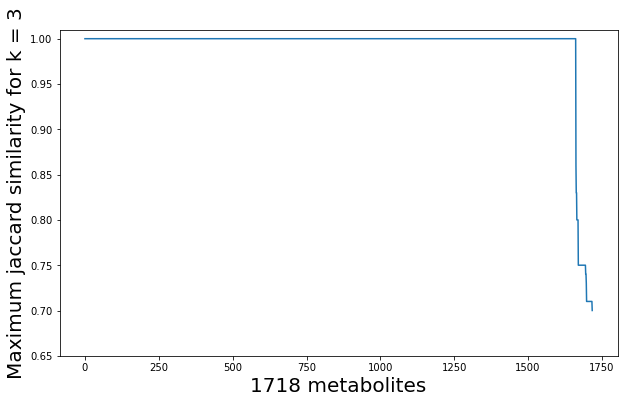

In [19]:
subset_final_df = final_df[final_df['max_jaccard'] >= 0.7]

ax = subset_final_df['max_jaccard'].plot(x='metabolite_ID',figsize=(10,6))

ax.set_ylim(0.65, 1.01)
ax.set_xlabel('%s metabolites'%len(subset_final_df['max_jaccard']),size=20)
ax.set_ylabel('Maximum jaccard similarity for k = %s'%k_value,size=20)

ax

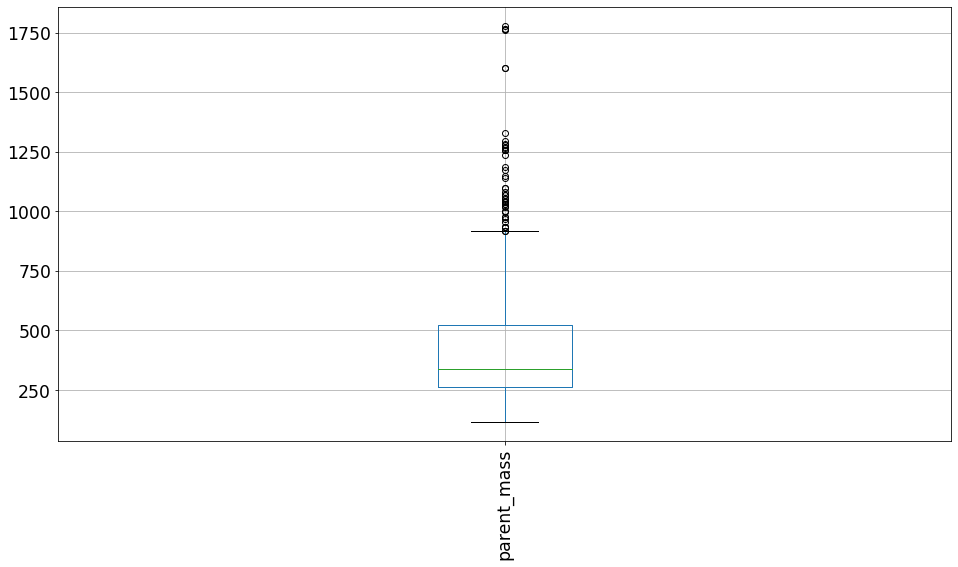

In [20]:
boxplot = pd.DataFrame(subset_final_df['parent_mass']).boxplot(figsize=[16,8],rot=90,fontsize='xx-large')

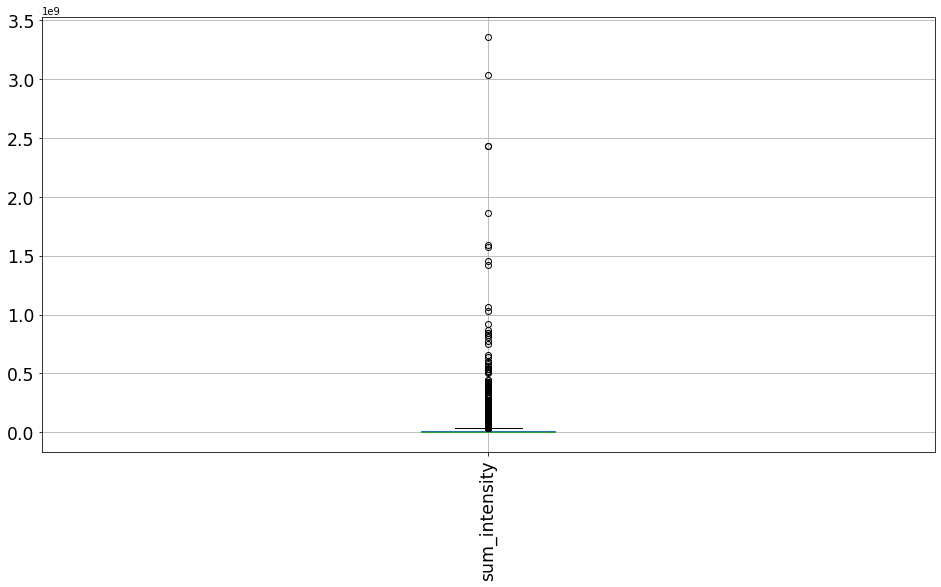

In [21]:
boxplot = pd.DataFrame(subset_final_df['sum_intensity']).boxplot(figsize=[16,8],rot=90,fontsize='xx-large')

In [23]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
run_time = "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
print(run_time)

00:18:23.34
